In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2025-05-09 08:55:03.636991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 08:55:03.637039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 08:55:03.637722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 08:55:03.642669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 🏈 Predicting Blitzes Using Pre-Snap Behavior

**By:** Christopher Doyle, Hans Elasri, Thomas Garity, Rishi Hazra, and Christopher Ruaño

## Final Model Pipeline

**Here is a high-level overview of the pipeline. Continue scrolling to see a basic implementation with more detail on assumptions and design choices.**

--

For our final model, we will adopt an RNN architecture. While some elements (like the hyperparameters, specific architecture, and feature selection) will be determined as we iterate, we will begin with a baseline model and then iteratively improve it.

We will iterate through the following approaches:
1. **Baseline RNN**: Feed through sequences of N rows of data. Each row corresponds to one play, and sequence is made up of N consecutive plays. The final play is the target -- the model must predict whether or not a blitz occurred in the final play.
2. **Frame-by-Frame RNN:** Feed through sequences of N rows of data. Each row corresponds to one frame of a single play. The final frame is the target -- the model must predict whether or not a blitz occurred within this play. 
3. **Mixture of Both:** Run both types of RNN. Combine the hidden states before a MLP head predicts the final blitz / no blitz output.

Our Pipeline will be as follows:

1. **PREPROCESSING**
   1. One hot encode categorical variables (teams, positions, formations)
   2. Drop columns that are un-usable.
   3. Create sequences, using a sliding window. Write a function for creating sequences -- we want the sliding window size to be flexible (we may want to change this later)
2. **MODELING**
   1. Define the architecture; the input should be N * (sequence length) * (number of features)
   2. Work with some sort of RNN units -- either RNN, GRU, or LSTM
   3. Output of final dense layer should be one logits with sigmoid activation for binary classification.
   4. We will minimize the binary cross-entropy loss -- this is the most logical approach, as we have chosen to have 1 logit.
3. **TRAINING**
   1. Train the model on the training data. Log loss, accuracy, and validation accuracy
   2. Plot training results over each epoch

### Preprocessing 
Using similar logic to the logistic regression, we:
- one-hot encode categorical variables (teams, positions, formations)
- cast boolean variables to integers
- drop columns that are un-usable
- fill Nans with 0 -- these mainly correspond to boolean variables for players whose positions do not apply (i.e. defensive stats for an offensive player), so zeroes are appropriate

To obtain our target label, we merge in from the `blitz_outcome` df. In our next imeplementation, we would save those blitz labels to the .csv file itself.

The next step is creating sequences. This is the format ready for the model. We have begun with a sequence length of 5, as this allows us to summarize any trends in the current drive, while also peeking at the previous drive as well. In the future we might experiment with:
- very large (30+) sequence lengths to capture multiple possessions from both teams
- recreate this logic at the frame-level; so we are looking more at real-time decisions (this is closer to our problem statement)


NOTE: We have cut off our dataset at only 2 games here. Change the `cutoff` argument to `None` to use the full dataset.

 

In [2]:
# Import dataframe
df = pd.read_csv('nontime_data.csv')
blitz_outcome = pd.read_csv('blitz_outcome.csv')

/tmp/ipykernel_10228/4249411861.py:2: DtypeWarning: Columns (420,421,422,423,424,425,426,427,428,429,430,431,432,435,436,437,438,440,441) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nontime_data.csv')


In [3]:
# Use the existing mapping of plays --> blitzes to add the target column
df = df.merge(blitz_outcome[['gameId', 'playId', 'blitzOutcome']], 
              on=['gameId', 'playId'], 
              how='left'
          )

In [4]:
# fill all missing categorical fields
categorical_cols = []
for col in df.select_dtypes(include=['object']).columns:
    if col not in ['gameId', 'playId', 'nflId']:
        categorical_cols.append(col)
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# one-hot encode categorical cols
df = pd.get_dummies(
    df,
    columns=categorical_cols,
    drop_first=True
)

# drop any remaining object-type columns from X
for col in df.select_dtypes(include=['object']).columns:
    df = df.drop(columns=[col])

# Convert boolean columns to integers (0/1) first
bool_cols = df.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df[col] = df[col].astype(int)

# Drop remaining rows with any NaN
df = df.dropna(subset=['blitzOutcome', 'quarter', 'down', 'yardsToGo', 'yardlineNumber', 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'expectedPoints'])

# Fill remaining NaNs with 0
df = df.fillna(0)

In [5]:
def create_sequences(df, n=5, target_col='blitzOutcome', step=1, cutoff=2):
    """
    Create sequences of n consecutive plays for RNN input with overlapping windows.
    
    Parameters:
    -----------
    df : DataFrame with last frame of each play
    n : Sequence length (number of plays to include in each sequence)
    target_col : Column name for the target variable (blitz indicator)
    step : Step size for sliding window (1 = maximum overlap, n = no overlap)
    cutoff : how many games to repeat this process for (for prototyping)

    Returns:
    --------
    X : numpy array of shape (num_sequences, n, num_features)
        Sequences of n plays with features
    y : numpy array of shape (num_sequences,)
        Target values indicating whether the n+1th play was a blitz
    play_ids : list of tuples
        Identifiers for the play following each sequence (for reference)
    """
    X = []
    y = []
    play_ids = []
    
    # list of unique games
    games = df['gameId'].unique()
    
    # Handle cutoff=None
    if cutoff is None:
        cutoff = len(games)

    # Print number of games you are sampling from
    print(f'Sampling from {cutoff} games')

    for game_id in games[:cutoff]:
        # Get plays for this game and sort chronologically
        game_plays = df[df['gameId'] == game_id].sort_values(['quarter', 'gameClock'], ascending=[True, False])
        
        # Get the length of this game in plays
        game_length = len(game_plays)
        
        # Skip games that are too short for our sequence length
        if game_length <= n:
            continue
            
        # Specify which features to use
        feature_cols = [col for col in df.columns if col not in ['gameId', 'playId', 'blitzOutcome']]
        
        # Convert to numpy for faster operations
        plays_array = game_plays[feature_cols].values
        targets_array = game_plays[target_col].values if target_col in game_plays.columns else None
        play_ids_array = game_plays['playId'].values

        # Create overlapping windows
        for i in range(0, game_length - n, step):
            # Get n consecutive plays for X
            sequence = plays_array[i:i+n]
            
            # Skip sequences with NaN values if needed
            # Although we should not have any at this point
            if np.isnan(sequence).any():
                # Flag it so we can debug
                print('skipping')
                continue
                
            # Add the sequence to our dataset
            X.append(sequence)
            
            # Get target from the n+1th play (if target column exists)
            if targets_array is not None:
                y.append(targets_array[i+n])
                
            # Keep track of which play this prediction is for
            # This is mainly for interpretability
            play_ids.append((game_id,play_ids_array[i+n]))
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y) if targets_array is not None else None
    
    print(f"Created {len(X)} sequences of length {n}")
    print(f"X shape: {X.shape}")
    if y is not None:
        print(f"y shape: {y.shape}")
    
    return X, y, play_ids

In [6]:
# Prepare sequences
X, y, play_ids = create_sequences(df, n=5, target_col='blitzOutcome', step=1, cutoff=None)

# Split into 80% training and 20% validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Take leftover 20% and split into 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Sampling from 31 games
Created 3519 sequences of length 5
X shape: (3519, 5, 1968)
y shape: (3519,)


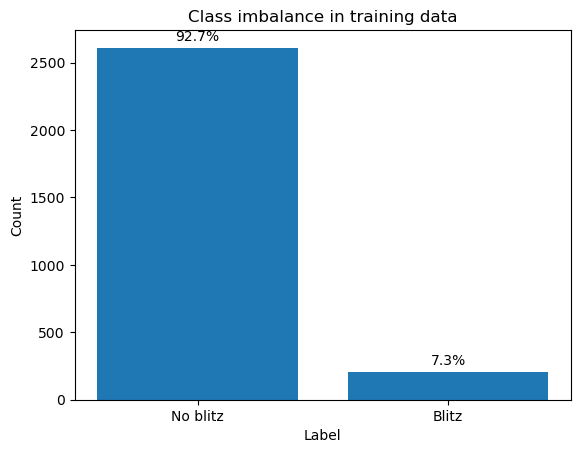

In [7]:
# Count occurrences of each label
labels, counts = np.unique(y_train, return_counts=True)
label_names = ['No blitz', 'Blitz']

# Calculate percentages
total = sum(counts)
percentages = [count / total * 100 for count in counts]

# Plot
plt.bar(label_names, counts)
plt.title('Class imbalance in training data')
plt.xlabel('Label')
plt.ylabel('Count')

# Add percentage labels on top of bars
for i, (count, pct) in enumerate(zip(counts, percentages)):
    plt.text(i, count + total * 0.01, f'{pct:.1f}%', ha='center', va='bottom')

plt.show()

**Observations**

This is roughly in-line with our % of blitzes across all plays -- so we can suggest that we are sampling correctly.

### Define RNN Model

We have not put extreme thought into this model yet -- that will be work for Milestone 5. However, with this working scaffolding, we can begin to iterate. Some design decisions we have made already are:
- **Tracking precision / recall** -- we know that blitzes are rare, so it is important that we know whether we are correctly identifying them (not just predicting the majority class)
- **Bidirectional LSTM layers** -- we were impressed by LSTMs in psets so have chosen them as the starting point. We have chosen bidirectional thinking that football strategies are somewhat bidirectional as well ; a defensive coordinator both looks back and previous plays and plans for potential future plays to lead their decisions. We need to test this logic further through experiments with regular and bidirectional plays.
- **Dropout** -- there is a risk of overfitting with this type of task (very noisy, small dataset), so we have added dropout to prevent overfitting.
- **Early Stopping** -- we have added early stopping to prevent overfitting.
- **Batch Normalization** -- same as above ; one more measure to prevent overfitting.

In [8]:
def create_blitz_rnn_model(n_timesteps, n_features, dropout_rate=0.3, lstm_units=256):
    model = Sequential([
        # Input layer
        Input(shape=(n_timesteps, n_features)),
        
        # Bidirectional LSTM layer
        Bidirectional(LSTM(256, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Second bidirectional LSTM layer
        Bidirectional(LSTM(256)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Dense hidden layer
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Dense hidden layer
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Output layer with 2 neurons (probability of blitz and no blitz)
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model with binary cross-entropy loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )
    
    return model

In [9]:
RNN_model = create_blitz_rnn_model(n_timesteps=X.shape[1], n_features=X.shape[2], dropout_rate=0.2)

2025-05-09 08:55:28.139351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:3e:00.0, compute capability: 8.9


### Training Run

Keep in mind, this is a demo -- we would run this for more epochs and tune our hyperparameters for our final model.

Be sure to update the # of epochs to be greater than 1.

In [10]:
callbacks = [
    EarlyStopping(monitor='val_recall', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
    ModelCheckpoint('best_blitz_model.h5', save_best_only=True)
]

# Use class weighting to adjust for massive class imbalance:
from sklearn.utils import class_weight

# Compute weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


history = RNN_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    epochs=25,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/25


2025-05-09 08:55:39.160095: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-05-09 08:55:40.925812: I external/local_xla/xla/service/service.cc:168] XLA service 0x14e49c115340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-09 08:55:40.925849: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-05-09 08:55:40.930831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746795341.005919   22217 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/88 [===========================>..] - ETA: 0s - loss: 1.3015 - accuracy: 0.4835 - auc: 0.4935 - precision: 0.0779 - recall: 0.5468

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 9s 25ms/step - loss: 1.2829 - accuracy: 0.4845 - auc: 0.4933 - precision: 0.0756 - recall: 0.5415 - val_loss: 0.5954 - val_accuracy: 0.9460 - val_auc: 0.5335 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/25
88/88 [==============================] - 1s 8ms/step - loss: 0.9883 - accuracy: 0.5066 - auc: 0.5275 - precision: 0.0765 - recall: 0.5220 - val_loss: 0.5990 - val_accuracy: 0.8438 - val_auc: 0.5317 - val_precision: 0.0444 - val_recall: 0.1429 - lr: 0.0010
Epoch 3/25
88/88 [==============================] - 1s 12ms/step - loss: 0.8306 - accuracy: 0.5460 - auc: 0.6104 - precision: 0.0920 - recall: 0.5902 - val_loss: 0.2806 - val_accuracy: 0.9517 - val_auc: 0.4928 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/25
88/88 [==============================] - 1s 9ms/step - loss: 0.7010 - accuracy: 0.5783 - auc: 0.6926 - precision: 0.1152 - recall: 0.7171 - val_loss: 0.5094 - val_accuracy: 0.8409 -

In [11]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    metrics = ['accuracy', 'precision', 'recall']
    plt.figure(figsize=(15, 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Evaluate Model

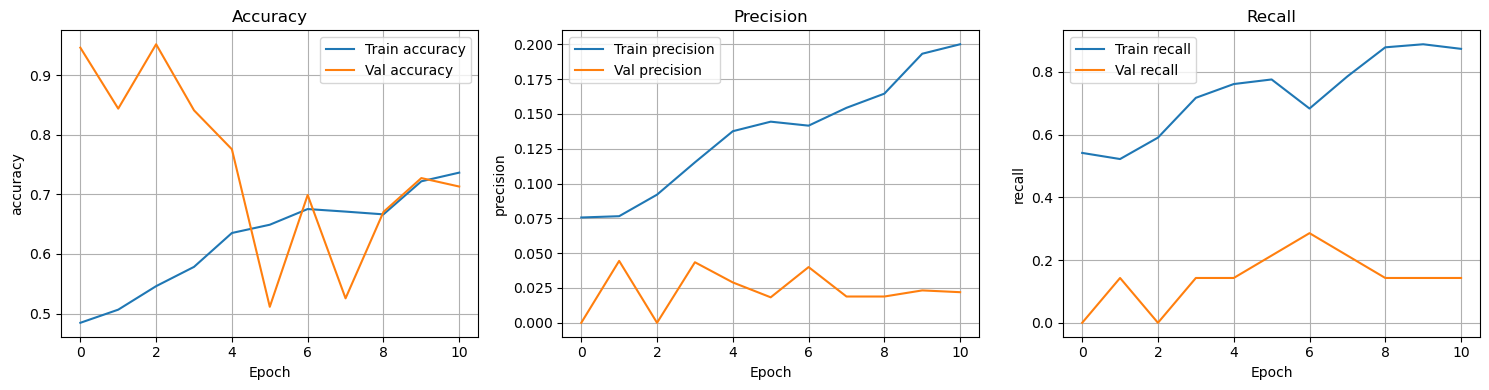

In [12]:
plot_training_metrics(history)

In [13]:
# Inspect Logs
loss, accuracy, auc, precision, recall = RNN_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

11/11 [==============================] - 0s 3ms/step - loss: 0.6012 - accuracy: 0.9176 - auc: 0.5891 - precision: 0.2000 - recall: 0.0385
Test Loss: 0.6012
Test Accuracy: 0.9176
Test AUC: 0.5891
Test Precision: 0.2000
Test Recall: 0.0385


**Observations**

The model predicts with a test accuracy of 66%, and a test recall of 30%. This means that the model predicts 1 in 3 blitzes -- this could be useful after all!

Some design decisions thus far are:
- Class weights -- this was a game changer
- LSTM layers -- bidirectional, since previous plays affect future ones, and potential future plays affect current ones (this may be too-flimsy logic)
- Early stopping based on recall -- as accuracy climbs, the recall tends to drop off (in early epochs, the model predicts too many blitzes)

However, there are a few design choices we can evaluate further:
- Scaling the dataset in preprocessing -- right now, we do nothing
- BinaryFocalCrossentropy loss did not help -- although maybe it could be worthwhile
- We don't know what the ideal input data looks like: is it better to feed through loads of plays, and let the model draw long-term predictions, or should we draw in shorter sequences?
- Same goes for step size in the sampling function
- Are we sure we have the right level of dropout?

## Input Feature Scaling

We perform an experiment to test for the best approach to scaling:
- Scale to [0, 1] -- many values are indicators on that interval anyways
- Standard scaler -- this likely will not work, since our data does not assume a gaussian distribution
- Scale to [-1, 1] -- the `tanh` activations in the LSTM layers may benefit from this
- No scaling (control) -- this is what we have currently -- and results have been okay (30% test recall)

In [16]:
# Create pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def test_scaler(X, y, results=None, scaler='None', n_trials=5):
    # Scale (or do not scale)

    if scaler == 'None':
        X_scaled = X

    else:
        # Manipulate data to be 2D (most scalers expect 2D data)
        # Suppose X shape is (n_samples, n_timesteps, n_features)
        n_samples, n_timesteps, n_features = X.shape
        
        # Reshape to 2D for scaling (merge samples and timesteps)
        X_2d = X.reshape(-1, n_features)

        if scaler == '[0,1]':
            # Normalize features to [0, 1] (handles mixed scales safely)
            scaler = MinMaxScaler()
    
        if scaler == '[-1,1]':
            scaler = MinMaxScaler(feature_range=(-1, 1))    
    
        if scaler == 'standard':
            scaler = StandardScaler()

        # Fit and transform
        X_scaled_2d = scaler.fit_transform(X_2d)
                
        # Reshape back to original 3D shape
        X_scaled = X_scaled_2d.reshape(n_samples, n_timesteps, n_features)

    # Split 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    for i in range(n_trials):
        print(f'Scaler: {scaler}, Trial: {i}')
        # Create model
        RNN_model = create_blitz_rnn_model(n_timesteps=X.shape[1], n_features=X.shape[2], dropout_rate=0.2)
    
        # Train and evaluate
        # Compute weights
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights = dict(enumerate(class_weights))
        
        # Train
        history = RNN_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            class_weight=class_weights,
            epochs=10,
            batch_size=32,
        )
    
        # Evaluate and save
        results = evaluate_and_save(RNN_model, X_test, y_test, ['scaler', scaler], i, results)

    return results

In [17]:
results = None
# Run the experiment for each type of scaler 5 times
for scaler in ['standard', 'None', '[0,1]', '[-1,1]']:
    # Run experiment
    results = test_scaler(X, y, results=results, scaler=scaler, n_trials=5)

Scaler: StandardScaler(), Trial: 0
Epoch 1/10
88/88 [==============================] - 7s 20ms/step - loss: 1.3419 - accuracy: 0.4948 - auc: 0.4827 - precision: 0.0724 - recall: 0.5024 - val_loss: 0.7758 - val_accuracy: 0.5384 - val_auc: 0.4587 - val_precision: 0.0615 - val_recall: 0.5000
Epoch 2/10
88/88 [==============================] - 1s 8ms/step - loss: 0.8421 - accuracy: 0.5268 - auc: 0.5944 - precision: 0.0878 - recall: 0.5854 - val_loss: 0.7070 - val_accuracy: 0.5838 - val_auc: 0.4596 - val_precision: 0.0530 - val_recall: 0.3750
Epoch 3/10
88/88 [==============================] - 1s 8ms/step - loss: 0.6778 - accuracy: 0.6078 - auc: 0.7048 - precision: 0.1220 - recall: 0.7073 - val_loss: 0.6305 - val_accuracy: 0.6705 - val_auc: 0.5439 - val_precision: 0.0636 - val_recall: 0.3500
Epoch 4/10
88/88 [==============================] - 1s 8ms/step - loss: 0.5447 - accuracy: 0.6895 - auc: 0.8188 - precision: 0.1625 - recall: 0.7854 - val_loss: 0.6167 - val_accuracy: 0.7301 - val_auc: 

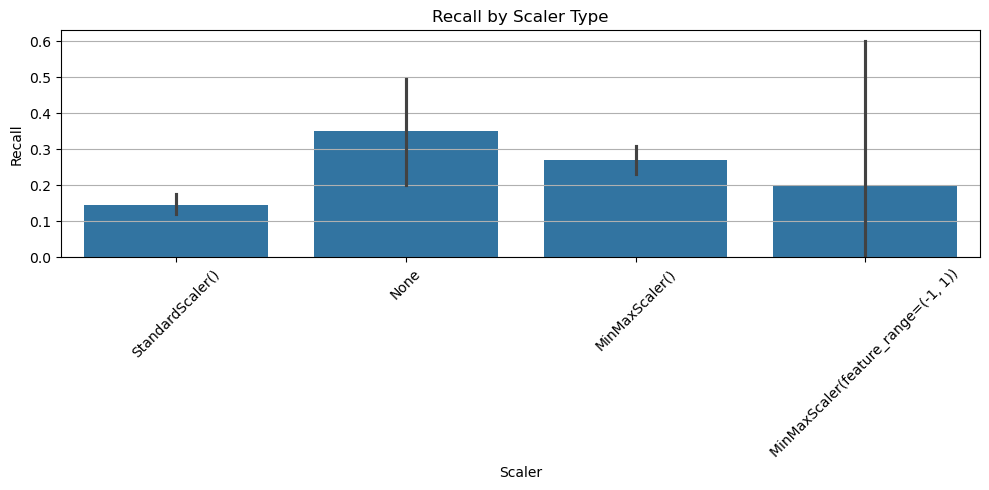

In [18]:
# Visualize results across different scalers

# Sort for consistent plotting
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='scaler', y='recall')
plt.title('Recall by Scaler Type')
plt.ylabel('Recall')
plt.xlabel('Scaler')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
# Show the results
results_df

,steps,scaler,loss,accuracy,auc,precision,recall
0,0,StandardScaler(),0.438172,0.855114,0.548663,0.081081,0.150
1,1,StandardScaler(),0.570387,0.832386,0.534902,0.085106,0.200
2,2,StandardScaler(),0.634585,0.815341,0.482549,0.050000,0.125
3,3,StandardScaler(),0.499508,0.863636,0.490964,0.062500,0.100
4,4,StandardScaler(),0.508900,0.830966,0.543581,0.065934,0.150
5,0,None,0.637309,0.646307,0.558754,0.059072,0.350
6,1,None,0.900360,0.542614,0.528445,0.067485,0.550
7,2,None,0.409389,0.883523,0.457436,0.062500,0.075
8,3,None,0.803103,0.634943,0.426073,0.042194,0.250
9,4,None,0.703350,0.649148,0.620501,0.084337,0.525


## Sequence Tuning

Here, we tune the parameters that control how sequences are constructed from the play-level data. This affects how much historical context the model sees, and how densely overlapping the training examples are.

In [20]:
# Used in experiments to create a df (first as a dict) of results
# var : {string, value} is the independent variable,
# where var[0] is a string label for the variable
import os

def evaluate_and_save(model, X_test, y_test, var, trial, results=None):
    # Evaluate
    loss, accuracy, auc, precision, recall = model.evaluate(X_test, y_test)

    if results is None:
        results = {
            'steps':[],
            var[0]:[],
            'loss':[],
            'accuracy':[],
            'auc':[],
            'precision':[],
            'recall':[]
        }

    # Save results
    results['steps'].append(trial)
    results[var[0]].append(var[1])
    results['loss'].append(loss)
    results['accuracy'].append(accuracy)
    results['auc'].append(auc)
    results['precision'].append(precision)
    results['recall'].append(recall)

    # Set up results directory if it doesn't exist
    os.makedirs(f'{var[0]}_experiment', exist_ok=True)
    
    # Save model
    model.save(f'{var[0]}_experiment/{var[1]}_{var[0]}_trial_{trial}.keras')

    return results

In [21]:
results = None

for n in range(1, 20, 2):
    for step in range(1, 5):
        # prepare your data
        X, y, play_ids = create_sequences(
            df,
            n=n,
            target_col='blitzOutcome',
            step=step,
            cutoff=None
        )
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # build & train
        RNN_model = create_blitz_rnn_model(
            n_timesteps=X.shape[1],
            n_features=X.shape[2],
            dropout_rate=0.2
        )
        cw = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        RNN_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            class_weight=dict(enumerate(cw)),
            epochs=25,
            batch_size=32,
            callbacks=callbacks
        )

        # evaluate + save
        results = evaluate_and_save(
            RNN_model,
            X_test, y_test,
            ('sequence_length', n),
            trial=step,
            results=results
        )

Sampling from 31 games
Created 3643 sequences of length 1
X shape: (3643, 1, 1968)
y shape: (3643,)
Epoch 1/25
92/92 [==============================] - 7s 20ms/step - loss: 1.1462 - accuracy: 0.5130 - auc: 0.5456 - precision: 0.0807 - recall: 0.5764 - val_loss: 0.8277 - val_accuracy: 0.0700 - val_auc: 0.4435 - val_precision: 0.0687 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/25
92/92 [==============================] - 1s 8ms/step - loss: 1.0670 - accuracy: 0.5388 - auc: 0.5304 - precision: 0.0752 - recall: 0.4975 - val_loss: 0.9982 - val_accuracy: 0.0823 - val_auc: 0.5494 - val_precision: 0.0695 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/25
92/92 [==============================] - 1s 8ms/step - loss: 0.8214 - accuracy: 0.5405 - auc: 0.5924 - precision: 0.0884 - recall: 0.6010 - val_loss: 0.8808 - val_accuracy: 0.1728 - val_auc: 0.4473 - val_precision: 0.0726 - val_recall: 0.9400 - lr: 0.0010
Epoch 4/25
92/92 [==============================] - 1s 8ms/step - loss: 0.7680 - accuracy: 0.5577 

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 1s 26ms/step - loss: 0.6502 - accuracy: 0.6481 - auc: 0.7892 - precision: 0.1477 - recall: 0.7647 - val_loss: 0.2804 - val_accuracy: 0.9289 - val_auc: 0.5378 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 6/25
29/29 [==============================] - 0s 10ms/step - loss: 0.5678 - accuracy: 0.6804 - auc: 0.8299 - precision: 0.1712 - recall: 0.8382 - val_loss: 0.6151 - val_accuracy: 0.8000 - val_auc: 0.4557 - val_precision: 0.0606 - val_recall: 0.1250 - lr: 0.0010
Epoch 7/25
29/29 [==============================] - 0s 10ms/step - loss: 0.5322 - accuracy: 0.7082 - auc: 0.8388 - precision: 0.1745 - recall: 0.7647 - val_loss: 1.7191 - val_accuracy: 0.0711 - val_auc: 0.4993 - val_precision: 0.0711 - val_recall: 1.0000 - lr: 0.0010
Epoch 8/25
29/29 [==============================] - 0s 10ms/step - loss: 0.5115 - accuracy: 0.6748 - auc: 0.8663 - precision: 0.1706 - recall: 0.8529 - val_loss: 0.4370 - val_accuracy: 0.9156 - val_a

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 25ms/step - loss: 0.3824 - accuracy: 0.7520 - auc: 0.9185 - precision: 0.1887 - recall: 0.9434 - val_loss: 0.2266 - val_accuracy: 0.9455 - val_auc: 0.6062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 9/25
28/28 [==============================] - 0s 11ms/step - loss: 0.3302 - accuracy: 0.8055 - auc: 0.9408 - precision: 0.2217 - recall: 0.8868 - val_loss: 0.3706 - val_accuracy: 0.9409 - val_auc: 0.4896 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 10/25
28/28 [==============================] - 0s 10ms/step - loss: 0.3495 - accuracy: 0.8191 - auc: 0.9315 - precision: 0.2376 - recall: 0.9057 - val_loss: 0.8465 - val_accuracy: 0.4000 - val_auc: 0.5072 - val_precision: 0.0522 - val_recall: 0.5833 - lr: 0.0010
Epoch 11/25
7/7 [==============================] - 0s 4ms/step - loss: 0.5528 - accuracy: 0.9455 - auc: 0.5467 - precision: 0.0000e+00 - recall: 0.0000e+00
Sampling from 31 games
Created 830

In [22]:
def summarize_results(results, tuning_param):
    results_df = pd.DataFrame(results)

    if tuning_param not in results_df.columns:
        raise ValueError(f"'{tuning_param}' not found in results.")

    summary = results_df.groupby(tuning_param).agg({
        'recall': ['mean', 'std'],
        'precision': ['mean', 'std'],
        'accuracy': ['mean', 'std'],
        'auc': ['mean', 'std'],
        'loss': ['mean', 'std']
    }).reset_index()

    summary.columns = [tuning_param, 'recall_mean', 'recall_std',
                       'precision_mean', 'precision_std',
                       'accuracy_mean', 'accuracy_std',
                       'auc_mean', 'auc_std',
                       'loss_mean', 'loss_std']

    return summary.sort_values(by='recall_mean', ascending=False)

# show the results
summary = summarize_results(results, tuning_param='sequence_length')
summary

,sequence_length,recall_mean,recall_std,precision_mean,precision_std,accuracy_mean,accuracy_std,auc_mean,auc_std,loss_mean,loss_std
0,1,0.118333,0.157797,0.031775,0.037758,0.865246,0.074225,0.553297,0.067876,0.571921,0.064309
5,11,0.038043,0.076087,0.012238,0.024476,0.854988,0.079589,0.509568,0.027537,0.595717,0.011583
2,5,0.037500,0.075000,0.011538,0.023077,0.865716,0.076100,0.486097,0.140891,0.564213,0.071656
3,7,0.004545,0.009091,0.083333,0.166667,0.924295,0.009847,0.493520,0.061072,0.413063,0.106572
1,3,0.000000,0.000000,0.000000,0.000000,0.902774,0.017914,0.497130,0.062563,0.514510,0.118233
4,9,0.000000,0.000000,0.000000,0.000000,0.919322,0.022975,0.521534,0.051659,0.469593,0.042447
6,13,0.000000,0.000000,0.000000,0.000000,0.929825,0.015310,0.509568,0.070756,0.458458,0.068190
7,15,0.000000,0.000000,0.000000,0.000000,0.919249,0.008505,0.474207,0.042915,0.469515,0.059652
8,17,0.000000,0.000000,0.000000,0.000000,0.929620,0.013768,0.490514,0.031141,0.448078,0.139614
9,19,0.000000,0.000000,0.000000,0.000000,0.936560,0.014364,0.459961,0.075007,0.476846,0.048914


### Dropout Rate and LSTM Units
We tune dropout and LSTM units together to manage the trade-off between model capacity and overfitting in learning blitz patterns.

In [ ]:
# parameter grid
dropout_rates = [0.1, 0.2, 0.3, 0.4]
lstm_units_list = [128, 256, 512]
n_trials = 3

# loop thru combos
results = None
trial = 0

for dropout_rate in dropout_rates:
    for lstm_units in lstm_units_list:
        for i in range(n_trials):

            print(f'Trial {i+1}/{n_trials} — Dropout: {dropout_rate}, LSTM Units: {lstm_units}')

            # build model
            model = create_blitz_rnn_model(
                n_timesteps=X.shape[1],
                n_features=X.shape[2],
                dropout_rate=dropout_rate,
                lstm_units=lstm_units
            )

            # compile
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'AUC', 'Precision', 'Recall']
            )

            # class weights
            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights = dict(enumerate(class_weights))

            # train
            model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                class_weight=class_weights,
                epochs=10,
                batch_size=32,
                verbose=0
            )

            # save results
            tag = f'dropout{dropout_rate}_lstm{lstm_units}'
            results = evaluate_and_save(
                model,
                X_test,
                y_test,
                var=('config', tag),
                trial=trial,
                results=results
            )
            trial += 1

In [ ]:
summary = summarize_results(results, tuning_param='config')
summary

## Learning Rate
We experiment with learning rates to find a balance between fast convergence and stable, accurate blitz predictions.

In [ ]:
# lrs to test
learning_rates = [0.01, 0.001, 0.0005, 0.0001]
n_trials = 5

# loop thru lrs
results = None
trial = 0

for lr in learning_rates:
    for i in range(n_trials):
        print(f'Trial {i+1}/{n_trials} — Learning rate: {lr}')

        # create model
        model = create_blitz_rnn_model(
            n_timesteps=X.shape[1],
            n_features=X.shape[2],
            dropout_rate=0.3,
            lstm_units=256
        )

        # compile
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy', 'AUC', 'Precision', 'Recall']
        )

        # class weights
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights = dict(enumerate(class_weights))

        # train
        model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            class_weight=class_weights,
            epochs=10,
            batch_size=32,
            verbose=0
        )

        # log and save
        tag = f'lr{lr}'
        results = evaluate_and_save(
            model,
            X_test,
            y_test,
            var=('lr', tag),
            trial=trial,
            results=results
        )
        trial += 1

In [ ]:
# output results
summary = summarize_results(results, tuning_param='lr')
summary

## Binary Focal Loss
We use binary focal loss to address class imbalance by making the model focus more on misclassified examples rather than defaulting to the majority class.

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy

# loss fns to compare
loss_types = {
    'bce': BinaryCrossentropy(),
    'focal': BinaryFocalCrossentropy(
        gamma=2.0,
        alpha=0.25,
        from_logits=False,
        name='binary_focal_crossentropy'
    )
}

# loop thru loss fns
n_trials = 5
results = None
trial = 0

for loss_name, loss_fn in loss_types.items():
    for i in range(n_trials):
        print(f'Trial {i+1}/{n_trials} — Loss: {loss_name}')

        model = create_blitz_rnn_model(
            n_timesteps=X.shape[1],
            n_features=X.shape[2],
            dropout_rate=0.3,
            lstm_units=256
        )

        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss=loss_fn,
            metrics=['accuracy', 'AUC', 'Precision', 'Recall']
        )

        # Compute class weights for imbalance
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights = dict(enumerate(class_weights))

        callbacks = [EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)]

        model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            class_weight=class_weights,
            epochs=40,
            batch_size=32,
            callbacks=callbacks,
            verbose=0
        )

        results = evaluate_and_save(
            model,
            X_test,
            y_test,
            var=('loss_fn', loss_name),
            trial=trial,
            results=results
        )

        trial += 1

In [ ]:
summary = summarize_results(results, tuning_param='loss_fn')
summary

## Model Architecture  
We explore different model architectures to evaluate whether we can improve recall or achieve comparable performance with simpler, more efficient designs.

In [ ]:
def create_rnn_variant(n_timesteps, n_features, 
                       lstm_units=256, 
                       dropout_rate=0.3, 
                       bidirectional=True, 
                       num_lstm_layers=2, 
                       dense_width=512):
    
    def lstm_layer(return_sequences=False):
        base = LSTM(lstm_units, return_sequences=return_sequences)
        return Bidirectional(base) if bidirectional else base

    model = Sequential()
    model.add(Input(shape=(n_timesteps, n_features)))
    
    model.add(lstm_layer(return_sequences=(num_lstm_layers == 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    if num_lstm_layers == 2:
        model.add(lstm_layer(return_sequences=False))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(dense_width, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_width, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )

    return model

In [ ]:
import itertools

# architecture grid
lstm_units = 256

architectures = list(itertools.product(
    [256, 512],      # Dense width
    [True, False],   # Bidirectional
    [1, 2]           # LSTM layers
))

n_trials = 3
results = None
trial = 0

for dense_width, bidirectional, num_lstm_layers in architectures:
    for i in range(n_trials):
        config_name = f"lstm{lstm_units}_dense{dense_width}_{'bi' if bidirectional else 'uni'}_{num_lstm_layers}L"
        print(f"Trial {i+1}/{n_trials} — {config_name}")

        model = create_rnn_variant(
            n_timesteps=X.shape[1],
            n_features=X.shape[2],
            lstm_units=lstm_units,
            dense_width=dense_width,
            bidirectional=bidirectional,
            num_lstm_layers=num_lstm_layers
        )

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights = dict(enumerate(class_weights))

        model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            class_weight=class_weights,
            epochs=10,
            batch_size=32,
            verbose=0
        )

        results = evaluate_and_save(
            model,
            X_test,
            y_test,
            var=('architecture', config_name),
            trial=trial,
            results=results
        )
        trial += 1

In [ ]:
summary = summarize_results(results, tuning_param='architecture')
summary

## Final Model
Based on our experimentation, our final model architecture should be as follows.

In [ ]:
# Plug in final model architecture

In [ ]:
# Evaluate final model
loss, accuracy, auc, precision, recall = final_model.evaluate(X_test, y_test)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test AUC: {auc:.4f}")
print(f"Final Test Precision: {precision:.4f}")
print(f"Final Test Recall: {recall:.4f}")